# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 1.10.2021

Мягкий дедлайн: 17.10.2021 23:59 МСК

Жесткий дедлайн: 24.10.2021 23:59 МСК (1 неделя -- минус балл)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Загрузите решение в свой репозиторий на github и поделитесь [ссылкой на решение в форме](https://forms.gle/ZzCaqRj6bmfpSpyL7). Не забудьте дать доступ к Вашему репозиторию, что у преподавателей была возмоожность проверить работу.

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from itertools import combinations, product, permutations
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier


In [3]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
    
        """
        if self.use_PCA:
            self.pca = PCA(n_components = self.new_dim)
            X = self.pca.fit_transform(X)
        self.sc = StandardScaler()
        X = self.sc.fit_transform(X)
            
        sample_ind1 = np.random.choice(np.arange(0, X.shape[0]), int(1e6), True)
        sample_ind2 = np.random.choice(np.arange(0, X.shape[0]), int(1e6), True)

        while len(np.where(sample_ind1 == sample_ind2)[0]) != 0:
            sample_ind1[np.where(sample_ind1 == sample_ind2)[0]] = np.random.choice(np.arange(0, 
                                            X.shape[0]), len(np.where(sample_ind1 == sample_ind2)[0]))
            
        sigma = np.median(np.sum((X[sample_ind1] - X[sample_ind2])**2, axis = 1))

        self.weights = np.random.normal(loc = 0, scale = (1/sigma) ** 0.5, size = (X.shape[1], self.n_features))
        self.biases = np.random.uniform(low = -np.pi, high = np.pi, size = self.n_features)
        tr = np.cos(X.dot(self.weights) + self.biases)

        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        if self.classifier == 'svm':
            self.model = LinearSVC()
        
        self.model.fit(tr, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X = self.sc.transform(X)
            
        test = np.cos(X.dot(self.weights) + self.biases)

        return self.model.predict_proba(test)[:, 1]
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X = self.sc.transform(X)
                        
        test = np.cos(X.dot(self.weights) + self.biases)

        return self.model.predict(test)

In [5]:
rffp = RFFPipeline()
rffp.fit(x_train, y_train)
pred = rffp.predict(x_test)

In [6]:
accuracy_score(y_test, pred)

0.8674

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [6]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna 
from datetime import datetime as dt

In [7]:
pca = PCA(n_components = 50)
X_tr = pca.fit_transform(x_train)
X_tst = pca.transform(x_test)

Найдем параметры для бустинга

In [ ]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X_tr, y_train, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
 
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
 
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(test_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(test_y, pred_labels)
    return accuracy
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [9]:
best_params_pca = study.best_trial.params

Обучим и получим результаты для бустинга (с PCA и без)

In [10]:
metrics = []

st = dt.now()
model = lgb.LGBMClassifier(**best_params_pca)
model.fit(X_tr, y_train)
pred = model.predict(X_tst)
end = dt.now()

metrics.append(['boosting with pca', accuracy_score(y_test, pred), round((end - st).seconds/60., 2)])

st = dt.now()
model = lgb.LGBMClassifier(**best_params_pca)
model.fit(x_train, y_train)
pred = model.predict(x_test)
end = dt.now()

metrics.append(['boosting', accuracy_score(y_test, pred), round((end - st).seconds/60., 2)])

Обучим и проверим остальные модели, для ядрового SVM будем брать случайную подвыборку из всех объектов

In [12]:
models = {
    'linear SVM': LinearSVC(),
    'SVM with rbf kernel': SVC(kernel = 'rbf'),
    'random_fourier with pca and logreg': RFFPipeline(use_PCA = True, classifier='logreg'), 
    'random_fourier with pca and SVM': RFFPipeline(use_PCA = True, classifier='svm'),
    'random_fourier without pca and logreg': RFFPipeline(use_PCA = False, classifier='logreg'), 
    'random_fourier without pca and SVM': RFFPipeline(use_PCA = False, classifier='svm'),
}

ind = np.random.choice(np.arange(0, x_train.shape[0]), int(x_train.shape[0] * 0.6), False)
X_train = np.copy(x_train)[ind]
Y_train = np.copy(y_train)[ind]

for model_name, model in models.items():
        
    st = dt.now()
    if model_name == 'SVM with rbf kernel':
        model.fit(X_train, Y_train)
        
    else:
        model.fit(x_train, y_train)
    pred = model.predict(x_test)
    end = dt.now()
    print('model: ', model_name, ', execution time: ', round((end - st).seconds/60., 2), ' minutes') 
    
    metrics.append([model_name, accuracy_score(y_test, pred), round((end - st).seconds/60., 2)])

model:  linear SVM , execution time:  5.07  minutes
model:  SVM with rbf kernel , execution time:  6.45  minutes
model:  random_fourier with pca and logreg , execution time:  0.2  minutes
model:  random_fourier with pca and SVM , execution time:  6.25  minutes
model:  random_fourier without pca and logreg , execution time:  0.82  minutes
model:  random_fourier without pca and SVM , execution time:  6.65  minutes


In [14]:
import pandas as pd
metric_df = pd.DataFrame(metrics, columns = ['model', 'accuracy', 'time in minutes'])
metric_df

,model,accuracy,time in minutes
0,boosting with pca,0.8763,0.15
1,boosting,0.9060,2.48
2,linear SVM,0.8040,5.07
3,SVM with rbf kernel,0.8770,6.45
4,random_fourier with pca and logreg,0.8643,0.20
5,random_fourier with pca and SVM,0.8575,6.25
6,random_fourier without pca and logreg,0.8617,0.82
7,random_fourier without pca and SVM,0.8499,6.65


In [15]:
#сохраним результаты на всякий случай
metric_df.to_csv('metrics.csv')

Проанализируем результаты:

Бустинг с подобранными параметрами показывает самое высокое качество. Гиперпараметры подбирались на выборке с признаками из PCA, но самый лучший результат все равно получается на исходных признаках. 

Линейный SVM на исходных признаках дает самый худший результат из всех протестированных моделей, очевидно, что зависимость ожидается не линейная. Для ядрового SVM выбиралась случайная подвыборка из 0.6 всех объектов и его результат один из лучших, второй после бустинга.

Модели, обученные на случайных признаках, показывают также неплохой результат на фоне остальных моделей. Лучше метрика у логистической регрессии и обучается она значительно быстрее любой из представленных моделей. Бустинг на исходных признаках хоть и дает лучшее качество, но время его обучения в десять раз больше, чем у логистической регрессии со случайными признаками, SVM  обучается долго как на исходных признаках, так и со случайными признаками и его обучение для каких-то промышленных задач видится только с использованием подвыборок, но для этого изначально следует провести исследование размера подвыборки в зависимости от качества модели. Использование логистической регрессии со случайными признаками вполне возможно, соотношение качество-время обучения получается очень неплохим

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

Предварительное понижение размерности значительно сокращает время обучения обеих моделей, особенно логистической регрессии, касательно качества, то для обеих моделей оно немного выше с использованием PCA.

Если брать n_features меньше 1000, то качество значительно хуже и растет с добавлением признаков. Если брать n_features больше тысячи, то качество в тысячных долях колеблется около 0.86, то есть почти не меняется. Но с увеличением количества признаков, ожидаемо растет и время обучения

Обучение логистической регрессии значительно быстрее, чем SVM: логистическая регрессия обучается меньше минуты, в то время, как SVM 6 минут. По качеству модели похожи, у обеих около 0.86

In [29]:
n_features_lr = np.arange(100, 6100, 100)
res, times = [], []

for n_features in n_features_lr:
    
    model = RFFPipeline(use_PCA = True, n_features = n_features, classifier='logreg')
    st = dt.now()
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    end = dt.now()
    res.append(accuracy_score(y_test, pred))
    times.append(round((end - st).seconds/60., 2))

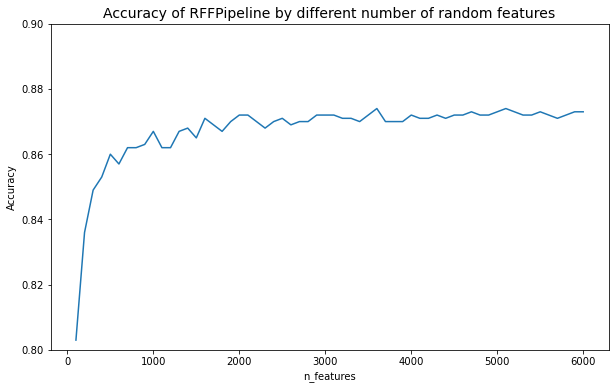

In [34]:
plt.figure(figsize=(10, 6))

plt.plot(n_features_lr, np.around(res,3))
plt.title("Accuracy of RFFPipeline by different number of random features", fontsize = 14)
plt.xlabel('n_features')
plt.ylabel('Accuracy')
plt.ylim(0.8, 0.9)
None

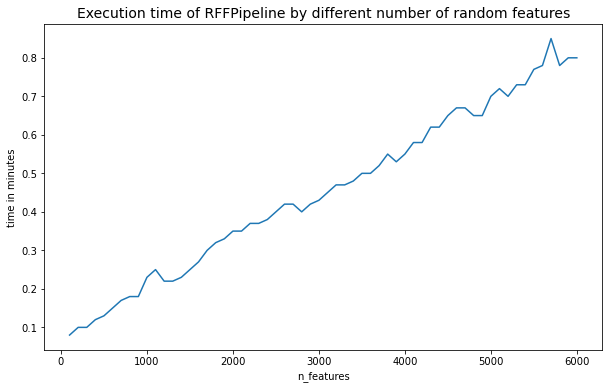

In [31]:
plt.figure(figsize=(10, 6))

plt.plot(n_features_lr, times)
plt.title("Execution time of RFFPipeline by different number of random features", fontsize = 14)
plt.xlabel('n_features')
plt.ylabel('time in minutes')
None

### Бонус

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', 
                 tranform = ['cos'], p = None):

        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.tranforms = tranform
        self.p = p
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
    
        """

        if self.use_PCA:
            self.pca = PCA(n_components = self.new_dim)
            X = self.pca.fit_transform(X)
            
        self.sc = StandardScaler()
        X = self.sc.fit_transform(X)    
        
        sample_ind1 = np.random.choice(np.arange(0, X.shape[0]), int(1e6), True)
        sample_ind2 = np.random.choice(np.arange(0, X.shape[0]), int(1e6), True)

        while len(np.where(sample_ind1 == sample_ind2)[0]) != 0:
            sample_ind1[np.where(sample_ind1 == sample_ind2)[0]] = np.random.choice(np.arange(0, 
                                            X.shape[0]), len(np.where(sample_ind1 == sample_ind2)[0]))
            
        sigma = np.median(np.sum((X[sample_ind1] - X[sample_ind2])**2, axis = 1))

        self.weights = np.random.normal(loc = 0, scale = (1/sigma) ** 0.5, size = (X.shape[1], self.n_features))
        self.biases = np.random.uniform(low = -np.pi, high = np.pi, size = self.n_features)
        X = self.transform(X.dot(self.weights) + self.biases)

            
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        if self.classifier == 'svm':
            self.model = LinearSVC()
        if self.classifier == 'sgd':
            self.model = SGDClassifier()
        if self.classifier == 'random_forest':
            self.model = RandomForestClassifier(**best_params_rf)
        if self.classifier == 'boosting':
            self.model = lgb.LGBMClassifier(**best_params_pca)
            
        self.model.fit(X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
            
        X = self.sc.transform(X)
            
        X = self.transform(X.dot(self.weights) + self.biases)
            
        return self.model.predict_proba(X)[:, 1]
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)
        X = self.sc.transform(X)
        
        X = self.transform(X.dot(self.weights) + self.biases)

        return self.model.predict(X)

    def transform(self, X):
        for transfrom in self.tranforms:
            if transfrom == 'cos':
                X = np.cos(X)
            if transfrom == 'sin':
                X = np.sin(X)
            if transfrom == 'sign':
                X = np.sign(X)
            if transfrom == 'log':
                X = np.log(np.abs(X)) 
            if transfrom == 'sqrt':
                X = np.sqrt(np.abs(X))
            if transfrom == 'poly':
                X = (X)**self.p           
        return X

Как классификатор был добавлен помимо линейных моделей случайный лес, подберем для него параметры

In [ ]:
from sklearn.model_selection import cross_validate

def objective(trial:optuna.trial.Trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 200),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
    }


    clf = RandomForestClassifier(random_state=42, **params)
    scores = cross_validate(clf, X_tr, y_train, verbose=1,
                n_jobs=-1, scoring='accuracy', cv=4)
    return scores["test_score"].mean()


studies = optuna.create_study(direction='maximize')
studies.optimize(objective, n_trials=20)
best_params_rf = studies.best_trial.params

In [43]:
transforms = ['cos', 'sign', 'log', 'sqrt']
acc = []

for transform in transforms:
    st = dt.now()
    model = RFFPipeline(tranform = [transform])
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    end = dt.now()
    acc.append(accuracy_score(y_test, pred))
    print('trasform features as ', transform, ' , accuracy = ', accuracy_score(y_test, pred))

trasform features as  cos  , accuracy =  0.8629
trasform features as  sign  , accuracy =  0.8232
trasform features as  log  , accuracy =  0.8351
trasform features as  sqrt  , accuracy =  0.8432


In [44]:
for p in np.arange(2,6):
    st = dt.now()
    model = RFFPipeline(tranform = ['poly'], p = p)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    end = dt.now()
    acc.append(accuracy_score(y_test, pred))
    print('trasform features as degree', p, ' , accuracy = ', accuracy_score(y_test, pred))

trasform features as degree 2  , accuracy =  0.8514
trasform features as degree 3  , accuracy =  0.8567
trasform features as degree 4  , accuracy =  0.8602
trasform features as degree 5  , accuracy =  0.8546


In [48]:
for clf in ['logreg','sgd', 'random_forest', 'boosting']:
    st = dt.now()
    model = RFFPipeline(classifier=clf)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    end = dt.now()
    acc.append(accuracy_score(y_test, pred))
    print(clf, ' classifier accuracy is ', accuracy_score(y_test, pred))
    print('execution time is ', round((end - st).seconds/60., 2))

logreg  classifier accuracy is  0.8617
execution time is  0.2
sgd  classifier accuracy is  0.8578
execution time is  0.87
random_forest  classifier accuracy is  0.856
execution time is  6.92
boosting  classifier accuracy is  0.8743
execution time is  3.63


Из признаков были добавлены: знак от скалярного произведения, возведение скалярного произведения в любую степень, а также логарифм от модуля скалярного произведения

Качество на всех признаках ниже, чем на косинусе от скалярного произведения - однако, для степеней 4 качество очень близко к косинусу

Кроме ранее добавленных классификаторов - логистической регрессии и SVM были добавлены SGDClassifier, Random Forest и  градиентный бустинг - качество Random Forest и SGDClassifierпримерно одинаковое, бустинг, как и ранее на исходных признаках, показывает лучшее значение метрики, так что такой результат ожидаем. 

Попробуем еще взять комбинации разных функций для случайных признаков, посмотрим, что получится

In [55]:
transforms = [['cos', 'poly'], ['log', 'poly'], ['poly', 'cos']]

for transform in transforms:
    st = dt.now()
    model = RFFPipeline(tranform = transform, p = 4)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    end = dt.now()
    acc.append(accuracy_score(y_test, pred))
    print('trasform features as ', transform, ' , accuracy = ', accuracy_score(y_test, pred))

trasform features as  ['cos', 'poly']  , accuracy =  0.8506
trasform features as  ['log', 'poly']  , accuracy =  0.6895
trasform features as  ['poly', 'cos']  , accuracy =  0.7768


Ну, ничего хорошего. Лучшим вариантом из протестированных остается косинус, близко к нему по качеству возведение скалярного произведения в 4 степень